# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

In [0]:
#@title Install PyTorch
!pip install torch torchvision -q

In [0]:
# Importing

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch.nn.functional as F

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

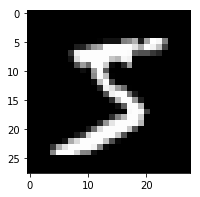

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:

In [0]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a tanh activation function to our output layer.

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer should have tanh applied
        x = torch.tanh(self.fc4(x))
        
        return x

## Model hyperparameters

In [0]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 28*28
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32


# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 28*28
# Size of *first* hidden layer in the generator
g_hidden_size = 32

In [8]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


## Discriminator and Generator Losses

Now we need to calculate the losses.

### Discriminator Losses

* For the discriminator, the total loss is the sum of the losses for real and fake images, d_loss = d_real_loss + d_fake_loss.
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [0]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    criterian = nn.BCEWithLogitsLoss()
    loss = criterian(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
        
    criterian = nn.BCEWithLogitsLoss()
    loss = criterian(D_out.squeeze(), labels)
    return loss

In [0]:
# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [11]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()

cuda_is_available = torch.cuda.is_available()

if cuda_is_available:
    G.cuda()
    D.cuda()

for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        if cuda_is_available:
            real_images.cuda()
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        d_optimizer.zero_grad()
        # 1. Train with real images

        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if cuda_is_available:
            z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images     
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)   
        
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if cuda_is_available:
            z.cuda()
        fake_images = G(z)

        if cuda_is_available:
            fake_images.cuda()
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    if cuda_is_available:
        fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
    
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Epoch [    1/   50] | d_loss: 1.3979 | g_loss: 0.6708
Epoch [    1/   50] | d_loss: 0.7066 | g_loss: 6.1117
Epoch [    1/   50] | d_loss: 1.3958 | g_loss: 0.8242
Epoch [    2/   50] | d_loss: 1.0132 | g_loss: 1.0516
Epoch [    2/   50] | d_loss: 1.3879 | g_loss: 1.0248
Epoch [    2/   50] | d_loss: 1.1710 | g_loss: 2.4717
Epoch [    3/   50] | d_loss: 1.2948 | g_loss: 0.8424
Epoch [    3/   50] | d_loss: 1.1237 | g_loss: 1.5781
Epoch [    3/   50] | d_loss: 1.1073 | g_loss: 1.4783
Epoch [    4/   50] | d_loss: 1.2720 | g_loss: 1.1437
Epoch [    4/   50] | d_loss: 1.2147 | g_loss: 0.9284
Epoch [    4/   50] | d_loss: 1.1219 | g_loss: 1.0770
Epoch [    5/   50] | d_loss: 1.3375 | g_loss: 0.8679
Epoch [    5/   50] | d_loss: 1.0849 | g_loss: 0.9454
Epoch [    5/   50] | d_loss: 1.1002 | g_loss: 1.0016
Epoch [    6/   50] | d_loss: 1.0618 | g_loss: 1.7297
Epoch [    6/   50] | d_loss: 1.1800 | g_loss: 2.2367
Epoch [    6/   50] | d_loss: 1.0034 | g_loss: 1.3217
Epoch [    7/   50] | d_loss

## Training loss
Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

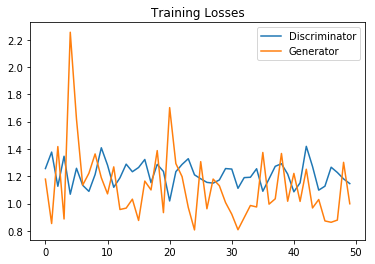

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training
Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

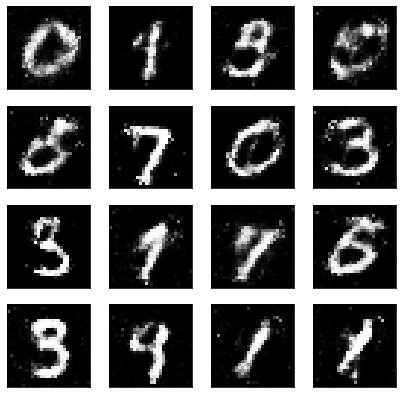

In [14]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

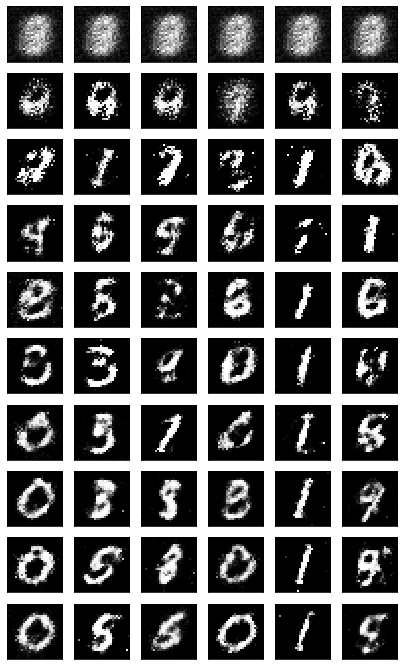

In [15]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)